# Linear algebra tools and demonstrations
By <a href="https://www.maxkapur.com/">Max Kapur</a>. Updated Nov. 9, 2019.

In [21]:
import numpy as np
from itertools import product, permutations
from scipy.linalg import expm
from scipy.optimize import minimize
from matplotlib.pyplot import plot, legend, title, figure, xlabel, ylabel

## Matrix constructors

Handy for homework.

In [22]:
# Yields the n by n Hilbert matrix
def Hilbert(n):
    out = np.empty((n,n))
    for i, j in product(range(n),repeat=2):
        out[i,j] =  1 / (i + j + 1) 
    return out 

g= Hilbert(5)
print(g)
print(np.linalg.cond(g))

[[1.         0.5        0.33333333 0.25       0.2       ]
 [0.5        0.33333333 0.25       0.2        0.16666667]
 [0.33333333 0.25       0.2        0.16666667 0.14285714]
 [0.25       0.2        0.16666667 0.14285714 0.125     ]
 [0.2        0.16666667 0.14285714 0.125      0.11111111]]
476607.25024100044


In [23]:
# Checkerboard of 1 and -1
def checkerboard(n):
    out = np.empty((n,n))
    for i, j in product(range(n),repeat=2):
        out[i,j] =  (-1)**(i+j) 
    return out

print(checkerboard(4))
print((1 - checkerboard(4)) / 2)

[[ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]
 [ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]]
[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [24]:
# A tridiagonal matrix with the given pattern
def tridiag(n,pattern=(-1,2,-1)):
    a, b, c = pattern
    return a*np.eye(n,k=-1) + b*np.eye(n) + c*np.eye(n, k=1)

print(tridiag(6,pattern=(-1, 4, 2)))

[[ 4.  2.  0.  0.  0.  0.]
 [-1.  4.  2.  0.  0.  0.]
 [ 0. -1.  4.  2.  0.  0.]
 [ 0.  0. -1.  4.  2.  0.]
 [ 0.  0.  0. -1.  4.  2.]
 [ 0.  0.  0.  0. -1.  4.]]


In [25]:
# Yields all square matrices of a given n whose entries are 0 or 1
def Hadamards(n):
    return np.array(list(product((0,1),repeat=n**2))).reshape(2**(n**2),n,n)

print(Hadamards(3)[[23,87,120]])

[[[0 0 0]
  [0 1 0]
  [1 1 1]]

 [[0 0 1]
  [0 1 0]
  [1 1 1]]

 [[0 0 1]
  [1 1 1]
  [0 0 0]]]


In [26]:
# Yields all permutation matrices of a given n
def perm_mats(n):
    perms = list(permutations(range(n)))
    out=np.zeros((len(perms), n, n))
    for j in range(len(perms)):
        for i in range(n):
            out[j,i,perms[j][i]]=1
    return out 

print(perm_mats(4)[[0,8,22]])

[[[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]]

 [[0. 1. 0. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]]


## Matrix transformations

Only one entry so far. <code>cofactor(A)</code> yields the cofactor matrix of $A$ as defined in Strang, *Linear Algebra and Its Applications* 4e, 4.3:

<p style="text-align: center;">$C_{ij} = (-1)^{i+j}\det M_{ij}$</p>

Where $M_{ij}$ is the $(n-1)\times(n-1)$ submatrix that results from eliminating the $i$ row and $j$ column of $A$. 

Then taking the dot product of any single row of $A$ with any single row of $C$ yields $\det{A}$. 

In [27]:
def cofactor(A):
    n = len(A)
    out = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            M = A
            M = np.delete(M, i, axis=0)
            M = np.delete(M, j, axis=1)
            out[i,j]=np.linalg.det(M)*(-1)**(i+j)
    return out

g = tridiag(4,pattern=(-1,4,3))
print(g)
print(cofactor(g))
# Use the dot product of any two rows to get the determinant
print(g[2] @ cofactor(g)[2])
# Numpy's evaluation of the same
print(np.linalg.det(g))

[[ 4.  3.  0.  0.]
 [-1.  4.  3.  0.]
 [ 0. -1.  4.  3.]
 [ 0.  0. -1.  4.]]
[[ 88.  19.   4.   1.]
 [-57.  76.  16.   4.]
 [ 36. -48.  76.  19.]
 [-27.  36. -57.  88.]]
409.0
409.00000000000017


## Demonstrations

### Visualizing the convergence of discrete and continuous Markov processes

Reference: Gilbert Strang, *Linear Algebra and Its Applications* 4e, sections 5.3 and 5.4.

<code>arr</code> or $A$ gives a random discrete Markov matrix indicating the relationship of next year&rsquo;s population to this one. It satisfies the defining property of a discrete Markov matrix:

<p style="text-align: center;">$\sum_{i=1}^n A_{ij} = 1$ for all $j$</p>

That is, the sum of each column is one.

<code>arr_cont</code> or $A'$ gives the continuously-compounded form of the same, which satisfies a similar equation:

<p style="text-align: center;">$\sum_{i=1}^n A'_{ij} = 0$ for all $j$</p>

<code>arr_cont</code> equals simply $A - I$. This is easy to see by analogy with $(1+r)^{t}$ and $e^{rt}$, respectively the discrete and continuous forms of the one-dimensional exponential growth equation. In matrix form, the equations become:

- Discrete:  $\qquad u_{t} = A^t u_0$
- Continuous: $\quad u(t) = \exp(tA')u_0$

Both matrices have the same eigenvectors (and the eigenvalues are simply reduced by one in <code>arr_cont</code>). The graph below suggests that the continuous form approaches its eigenvectors slightly faster.

In [28]:
n = 6
np.random.seed(1987)

# A random n-by-n Markov matrix
arr = np.random.random_sample((n,n))
arr = arr / arr.sum(axis=0)

# and its continuous form (just subtract I)
arr_cont = arr - np.eye(n)

# n random population start values
u0 = np.random.randint(51, size=n)

print(arr)
print(arr.sum(axis=0))

[[0.11181654 0.02909357 0.2179892  0.29565424 0.17371954 0.0716327 ]
 [0.11727295 0.1519251  0.15913957 0.06874233 0.15073924 0.52364584]
 [0.13912152 0.30975534 0.14804066 0.14492082 0.19171334 0.0938279 ]
 [0.4303738  0.286293   0.19879452 0.16772347 0.05583325 0.10939849]
 [0.14950011 0.08155211 0.05743246 0.20054737 0.28280312 0.16920595]
 [0.05191508 0.14138088 0.2186036  0.12241177 0.1451915  0.03228911]]
[1. 1. 1. 1. 1. 1.]


<code>arr</code> has its largest eigenvalue $\lambda_1 = 1$. Thus, we expect the matrix to converge on the corresponding eigenvector $\eta_1$. For our matrix $\eta_1$ is complex, so there will be oscillatory behavior as $t \to \infty$, but in this case the oscillations are gentle enough that they do not show on the plot.

In [29]:
# Eigenvalues of arr
print(np.linalg.eigvals(arr))
# First eigenvector of arr
print(np.linalg.eig(arr)[1][0])

[ 1.        +0.j          0.17975222+0.07357139j  0.17975222-0.07357139j
 -0.1769291 +0.1599462j  -0.1769291 -0.1599462j  -0.11104826+0.j        ]
[-0.38536198+0.j          0.22279832+0.27868169j  0.22279832-0.27868169j
 -0.16825134+0.43297401j -0.16825134-0.43297401j -0.47484858+0.j        ]


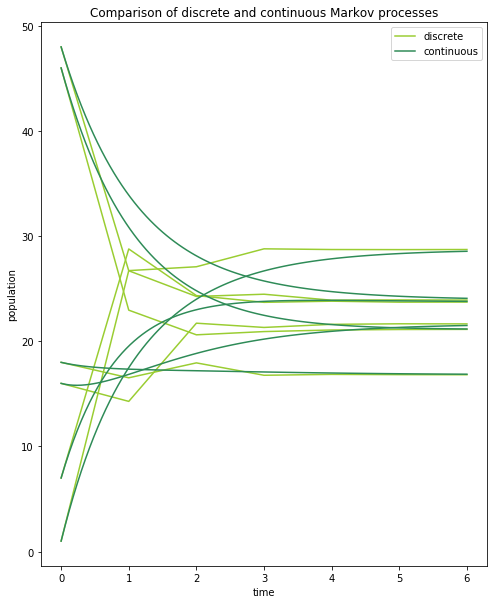

In [30]:
t = 6

# Discrete results from time 0 to t
results_discrete = np.stack([np.linalg.matrix_power(arr, i) @ u0 for i in range(t+1)])
x_discrete = range(t+1)

# Continuous results from time 0 to t
results_cont = np.stack([expm(t*arr_cont) @ u0 for t in np.linspace(0,t,101)])
x_cont = np.linspace(0,t,101)

# Plot
figure(figsize=(8,10))
ylabel('population')
xlabel('time')
title('Comparison of discrete and continuous Markov processes')

plot(x_discrete, results_discrete, color='yellowgreen')
plot(x_cont, results_cont, color='seagreen')

# Legend
plot([],[], color='yellowgreen', label='discrete')
plot([],[], color='seagreen', label='continuous')
legend()

### Visualizing the QR method for iteratively making a matrix upper triangular
Reference: Gilbert Strang, *Linear Algebra and Its Applications* 4e, section 7.3.

<p style="text-align: center;">Let $A_{k+1} = R_k Q_k$ where $Q_k R_k$ is the QR factorization of $A_k$.</p>

This process creates matrices similar to $A$ that get iteratively more upper triangular. The values along the diagonal then approach the eigenvalues of $A$.

Note that I leave the actual work of finding the QR factorizations to numpy. 

In [31]:
# Performs k iterations of the QR algorithm
def unshifted_qr(A, k):
    if k == 0:
        return A
    w = np.linalg.qr(unshifted_qr(A,k-1))
    return w[1] @ w[0]

# A random matrix
np.random.seed(2048)
A = np.random.random_sample((6,6))
iters = 120
demo_iters = 12
demo = np.empty((iters,6,6))
for i in range(iters):
    demo[i] = unshifted_qr(A, i)
with np.printoptions(precision=3, suppress=True):
    print(demo[0:3])

[[[ 0.59   0.137  0.662  0.987  0.897  0.579]
  [ 0.065  0.109  0.448  0.338  0.322  0.906]
  [ 0.101  0.751  0.827  0.677  0.247  0.248]
  [ 0.878  0.019  0.082  0.298  0.59   0.434]
  [ 0.444  0.104  0.253  0.368  0.651  0.283]
  [ 0.842  0.83   0.152  0.878  0.928  0.234]]

 [[ 2.388 -0.014  1.11   0.13   0.595 -0.24 ]
  [ 0.615  0.269  0.598  0.687  0.23   0.617]
  [ 0.951  0.735 -0.01   0.512 -0.032 -0.15 ]
  [-0.286  0.183 -0.044 -0.252 -0.099  0.092]
  [ 0.235  0.102 -0.104 -0.045  0.22  -0.079]
  [ 0.324  0.263 -0.294 -0.17   0.06   0.094]]

 [[ 2.834  0.024 -0.127  0.696 -0.002  0.748]
  [-0.     0.02  -0.72   0.262  0.358 -0.536]
  [-0.226 -0.747 -0.196 -0.4    0.042  0.106]
  [ 0.043 -0.165  0.109 -0.473 -0.028  0.005]
  [ 0.056  0.104  0.213  0.053  0.274 -0.075]
  [-0.041 -0.097 -0.176 -0.065 -0.092  0.25 ]]]


Sum up and plot the entries of the main diagonals and subdiagonals. The sum of the diagonal should stay constant since the trace equals the sum of the eigenvalues. The others should converge toward zero.

You can experiment with representing the convergence using the vector length, mean, or absolute-value sum of the diagonal entries instead. 

Text(0.5, 0, 'iterations')

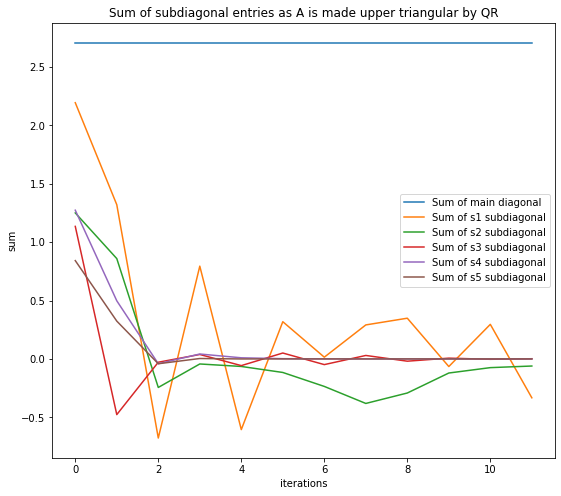

In [32]:
sums = np.array([[np.diag(demo[i],k).sum() for k in -np.arange(6)[::-1] ] for i in range(demo_iters)])
sums_x = range(demo_iters)

figure(figsize=(9,8))

for i in range(6)[::-1]:
    if i==5:
        plot(sums_x, sums[:,5], label='Sum of main diagonal'.format(5-i))
    if i!=5:
        plot(sums_x, sums[:,i], label='Sum of s{} subdiagonal'.format(5-i))
        
legend()
title('Sum of subdiagonal entries as A is made upper triangular by QR')
ylabel('sum')
xlabel('iterations')

In [33]:
print(np.linalg.eigvals(A))

[ 2.84203858+0.j         -0.92499769+0.j         -0.40057786+0.j
  0.50878917+0.20333826j  0.50878917-0.20333826j  0.17440639+0.j        ]


The $s_1$ subdiagonal (orange in the plot above) fails to converge. Instead, it oscillates because A has complex eigenvalues.

The following plot shows the sum of the $s_1$ subdiagonal through 120 iterations of QR.

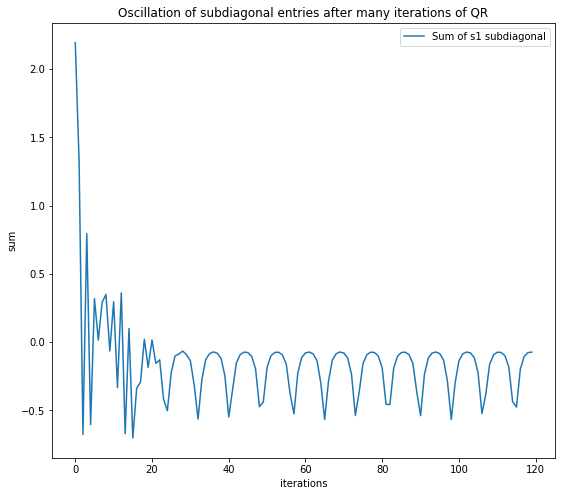

In [34]:
figure(figsize=(9,8))
plot([np.diag(i,-1).sum() for i in demo], label='Sum of s1 subdiagonal')
ylabel('sum')
xlabel('iterations')
title('Oscillation of subdiagonal entries after many iterations of QR')
legend()

### Comparison of iterative methods for solving Ax = b
Reference: Gilbert Strang, *Linear Algebra and Its Applications* 4e, section 7.4.

Here I compare three different techniques for splitting a matrix $A = S - T$ and solving $Ax = b$ iteratively using the sometimes-convergent difference equation $Sx_{k+1} = Tx_k + b$.

- Jacobi method: $S$ is the diagonal of $A$
- Gauss-Seidel method: $S$ is the lower triangular &ldquo;pail&rdquo; of $A$
- Successive overrelaxation method: Like Gauss-Seidel, but the diagonal entries are weighted in a clever way that makes iteration converge faster. Analogous to <a href="https://ocw.mit.edu/courses/mathematics/18-03sc-differential-equations-fall-2011/unit-ii-second-order-constant-coefficient-linear-equations/damped-harmonic-oscillators/MIT18_03SCF11_s13_2text.pdf">overdamping</a> in second order DEs. 

Included is a function that determines from $A$ the optimal $\omega$ to be used in SOR. 

In [35]:
def best_omega(A):
    """
    Computes the best omega value to use to split A for SOR.
    """
    L = np.tril(A, k=-1)
    D = np.diag(np.diag(A))
    U = np.triu(A, k= 1)
    mu2 = np.linalg.eigvals(np.linalg.inv(D) @ (-L - U)).max() ** 2
    return 2 * (1 - np.sqrt(1 - mu2) ) / mu2

def ST(A, omega=1):
    """
    Splits A into S - T in preperation for iterative solving of Ax = b.
    Defaults to omega=1 (Gauss-Seidel method).
    Setting omega=0 yields Jacobi split where S = diag(a)
    """
    if omega==0:
        S = np.diag(np.diag(A))
        T = S - A 
        return S, T
    L = np.tril(A, k=-1)
    D = np.diag(np.diag(A))
    U = np.triu(A, k= 1)
    S = D / omega + L
    T = (1 / omega - 1) * D - U
    return S, T 
    
def ST_iter(S, T, x0, b, n_iterations):
    """
    Recursively compute the nth iteration of A according to the
    difference equation Sx_k+1 = Tx_k + b.
    Will fail to converge for many matrices.
    """
    if n_iterations==0:
        return x0
    left = S
    right = T @ ST_iter(S, T, x0, b, n_iterations - 1) + b
    return np.linalg.solve(left, right)

In [36]:
np.random.seed(1987)

# Convergent example with tridiagonal A, random x0
A = np.eye(5) * 2 - np.eye(5,k=1) - np.eye(5,k=-1)
x0 = np.random.randint(0,100,size=5)
b = np.arange(12,17)
n_iterations = 30

print(A)
print(x0)

[[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]
[14 35 94 70 74]


Text(0.5, 1.0, 'Comparison of iterative methods for solving Ax = b')

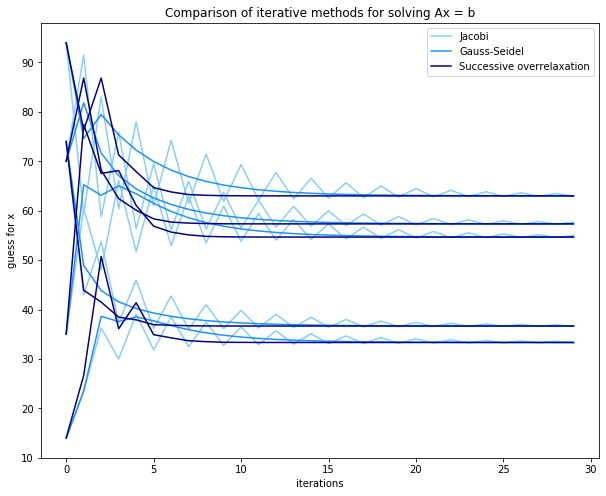

In [37]:
S, T = ST(A, omega=0)
jacobi = np.vstack([ST_iter(S, T, x0, b, n) for n in range(n_iterations)])

S, T = ST(A, omega=1)
GS = np.vstack([ST_iter(S, T, x0, b, n) for n in range(n_iterations)])

S, T = ST(A, omega=best_omega(A))
SOR = np.vstack([ST_iter(S, T, x0, b, n) for n in range(n_iterations)])

# Plot
figure(figsize=(10,8))
ylabel('guess for x')
xlabel('iterations')
plot(range(n_iterations), jacobi, color='lightskyblue')
plot(range(n_iterations), GS, color='dodgerblue')
plot(range(n_iterations), SOR, color='navy')

# Legend
plot([],[], color='lightskyblue', label='Jacobi')
plot([],[], color='dodgerblue', label='Gauss-Seidel')
plot([],[], color='navy', label='Successive overrelaxation')
legend()
title('Comparison of iterative methods for solving Ax = b')

My best guess vs. numpy&rsquo;s &ldquo;real&rdquo; answer. 

In [38]:
print(SOR[-1,:])
print(np.linalg.solve(A, b))

with np.printoptions(precision=5):
    print(SOR[-1,:] - np.linalg.solve(A, b))

[33.33333333 54.66666667 63.         57.33333333 36.66666667]
[33.33333333 54.66666667 63.         57.33333333 36.66666667]
[5.24594e-11 5.68150e-11 3.80211e-11 1.92912e-11 6.38067e-12]


### Solving a multivariate optimization problem
Reference: Gilbert Strang, *Linear Algebra and Its Applications* 4e, section 8.1.

I&rsquo;ll demonstrate how to use Scipy&rsquo;s <code>optimize</code> model to solve a linear programming problem. This is more of a coding exercise than a linear algebra execise, but there were some hitches in setting it up that are worth clarifying. 

The problem we&rsquo;re looking at is problem #9 from the text cited above:

![Problem 9](linalg-img1.png)

The author just wants us to set up the problem, but I will provide a full solution.

First, we must decide on our &ldquo;data structure.&rdquo; <code>scipy.optimize</code> wants our variable to be one dimensional, but this problem will make more sense if we can preserve the meshing of origin and destination implied in the problem. I organize the distances like this: 

$$D = \begin{bmatrix} 1000 & 2000 & 3000 \\ 1500 & 3000 & 3700 \end{bmatrix}$$

where the vertical axis gives the destination (Chicago, New England) and the horizontal axis gives the source (TX, CA, AK).

Then, if we store the number of barrels to be shipped in a 2-by-3 matrix $X$, the cost function is simply the Hadamard product $X \circ D$. Let&rsquo;s put that in Numpy.

In [39]:
# Cost matrix (D above)
distances = np.array([[1000, 2000, 3000],
                      [1500, 3000, 3700]])

# Cost function (what we will be minimizing)
def cost(x):
    # Restore the (2,3) shape because x gets flattened inside scipy.minimize
    x = x.reshape(2,3)
    return (distances * x).sum()

Now, we can start implementing our constraints. First, we have that each state produces exactly a million barrels of oil. In linear algebra terms, this means that summing over the columns of the cost matrix $X \circ D$ should yield a matrix of 1,000,000, repeated thrice.  That is, 

$$\sum_{\text{columns}} X \circ D = \begin{bmatrix} 1,000,000 & 1,000,000 & 1,000,000 \end{bmatrix}$$

<code>scipy.optimize</code> likes the constraints to be set equal to zero, so we subtract the millions matrix from the sums matrix to define <code>production_constraint(x)</code>.

In [40]:
def production_constraint(x):
    x = x.reshape(2,3)
    return x.sum(axis=0) - np.ones(3)*1e6

Similarly, the text says that Chicago needs 800,000 barrels of oil and New England needs 2,200,000. In similar fashion, we get our second constraint from comparing those numbers to the *rows* of the cost matrix:

$$\sum_{\text{rows}} X \circ D \geq \begin{bmatrix} 800,000 \\ 2,200,000 \end{bmatrix}$$

Why did I change the equality sign to an &ldquo;at least&rdquo;? I know from inspection that the optimal solution will never have us deliver *more* than the minimum amount of oil to each destination&mdash;this is a linear problem, after all. More importantly (and this is where I got stuck for a while), <code>scipy.optimize</code> <a href="https://github.com/scipy/scipy/issues/7314">throws an error if you give it only equality constraints</a>. 

In [41]:
def demand_constraint(x):
    x = x.reshape(2,3)
    return x.sum(axis=1) - np.array([8,22])*1e5

The third constraint is that all the entries of $X$ must be nonnegative. In Scipy, simple constraints like this are implemented as &ldquo;bounds.&rdquo;

In [42]:
bounds = [[0,None]]*6

Next, we bind the constraints into a list of dictionaries that <code>scipy.optimize</code> can understand. This is where I input those equality and inequality signs.

In [43]:
constraints = [{'type': 'eq', 'fun': production_constraint},
               {'type': 'ineq', 'fun': demand_constraint}]

The <code>minimize</code> function from <code>scipy.optimize</code> works iteratively, so we need to provide it with a guess for $X$, <code>x0</code>. Let&rsquo;s start by just sending the same amount of oil from each place. I chose numbers that, although not optimal, satisfy both constraints. 

In [44]:
x0 = np.array([[8e5 / 3]*3,
              [2.2e6 / 3]*3])

# Should both be zero
print(production_constraint(x0))
print(demand_constraint(x0))

[0. 0. 0.]
[0. 0.]


Now we let Scipy do its thing.

In [56]:
minimize(cost, x0=x0, constraints=constraints, bounds=bounds)

     fun: 7400000000.00025
     jac: array([1024., 2048., 3072., 1536., 3072., 3712.])
 message: 'Optimization terminated successfully.'
    nfev: 129
     nit: 17
    njev: 16
  status: 0
 success: True
       x: array([1.8452483e-08, 8.0000000e+05, 0.0000000e+00, 1.0000000e+06,
       2.0000000e+05, 1.0000000e+06])

In [57]:
answer = _.x.reshape(2,3)
answer_cost = _.fun
print(np.round(answer))
print(np.round(answer_cost))

[[      0.  800000.       0.]
 [1000000.  200000. 1000000.]]
7400000000.0


There&rsquo;s our answer. In plain English, we will achieve the lowest cost by having Chicago get all 800,000 of its oil barrels from nearbyish California. All the other oil goes to needy New England. Note that as expected, the optimal solution does achieve equality in the demand constraint. The cost itself is $7.4 billion.

In [62]:
!jupyter nbconvert linalg.ipynb

[NbConvertApp] Converting notebook linalg.ipynb to html
[NbConvertApp] Writing 633620 bytes to linalg.html
